In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# Load dataset
generation_data = pd.read_csv("Plant_1_Generation_Data.csv")

In [3]:
# Convert DATE_TIME to datetime format
generation_data["DATE_TIME"] = pd.to_datetime(generation_data["DATE_TIME"], dayfirst=True, errors='coerce')

In [4]:
# Feature Engineering
generation_data["Hour"] = generation_data["DATE_TIME"].dt.hour
generation_data["Day"] = generation_data["DATE_TIME"].dt.day
generation_data["Month"] = generation_data["DATE_TIME"].dt.month

In [5]:
# Select Features (only from generation data)
features = ["DC_POWER", "DAILY_YIELD", "TOTAL_YIELD", "Hour", "Day", "Month"]
target = "AC_POWER"

In [6]:
# Drop missing values
generation_data.dropna(subset=features + [target], inplace=True)

In [7]:
# Scaling Data
scaler = MinMaxScaler()
generation_data[features] = scaler.fit_transform(generation_data[features])

In [8]:
# Save the scaler for future use
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [9]:
# Prepare data for LSTM
lookback = 24  # Using past 24 hours of data to predict next hour
X, y = [], []
for i in range(lookback, len(generation_data)):
    X.append(generation_data[features].iloc[i - lookback:i].values)
    y.append(generation_data[target].iloc[i])
X, y = np.array(X), np.array(y)

In [10]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# LSTM Model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(lookback, len(features))),
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

C:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# Train LSTM
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 34s 16ms/step - loss: 179911.3906 - val_loss: 157382.8438
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 108212.0000 - val_loss: 8498.5508
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 8629.2100 - val_loss: 3963.6963
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 7018.7031 - val_loss: 4888.9976
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 6534.5088 - val_loss: 3343.1477
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 6285.6450 - val_loss: 3632.4604
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 5654.9443 - val_loss: 4382.9634
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 5793.5640 - val_loss: 3370.9763
Epoch 9/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 6239.7124 - val_loss: 3103.0222
Epoch 10/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 5387.8467 - val_loss: 3360.5625
Epoch 11/30
1719/1719 ━━━━━━━━━━━

In [13]:
# Save the trained model
model.save("lstm_solar_model.keras")

In [14]:
# Predictions
lstm_predictions = model.predict(X_test)

430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


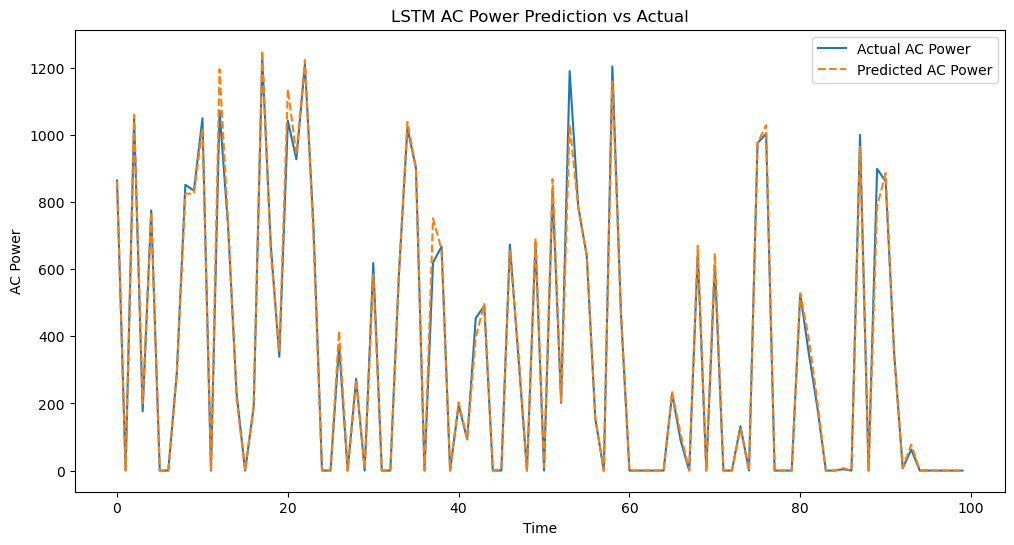

In [15]:
# Visualizing Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual AC Power")
plt.plot(lstm_predictions[:100], label="Predicted AC Power", linestyle="dashed")
plt.legend()
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.title("LSTM AC Power Prediction vs Actual")
plt.show()